In [1]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq, fftshift
from scipy.optimize import curve_fit
from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

[INFO][corrections] Numba not available, reverting to Numpy


In [2]:
channel_PIPS_trans

'SARES11-GES1:CH1_VAL_GET/data'

In [321]:
#scan_name ="timesan_monoFEL_7122eV_12.7uJ_140_142mm_a"
scan_name ="RuDimerACN_timescan_037"
#scan_name = 'Fluence_scan_7122.5eV_1ps_001'
#scan_name ="CytC_Fe2_7122eV_delayscan_002"


DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 42G
drwxrwsr-x. 187 17983 p17983  32K Jul 29 07:43 ..
-rw-r--r--.   1 17983 p17983 5.9G Jul 29 07:43 RuDimerACN_timescan_037_step0000.JF02T09V02.h5
-rw-r--r--.   1 17983 p17983 7.9G Jul 29 07:43 RuDimerACN_timescan_037_step0000.JF06T32V01.h5
-rw-r--r--.   1 root  p17983  59K Jul 29 07:44 RuDimerACN_timescan_037_step0000.BSREAD_CA.h5
-rw-r--r--.   1 17983 p17983 5.9G Jul 29 07:44 RuDimerACN_timescan_037_step0001.JF02T09V02.h5
-rw-r--r--.   1 17983 p17983 7.9G Jul 29 07:44 RuDimerACN_timescan_037_step0001.JF06T32V01.h5
-rw-r--r--.   1 root  p17983  58K Jul 29 07:44 RuDimerACN_timescan_037_step0001.BSREAD_CA.h5
-rw-r--r--.   1 root  p17983 162M Jul 29 07:44 RuDimerACN_timescan_037_step0000.BSREAD.h5
-rw-r--r--.   1 17983 p17983 5.9G Jul 29 07:44 RuDimerACN_timescan_037_step0002.JF02T09V02.h5
-rw-r--r--.   1 17983 p17983 7.9G Jul 29 07:44 RuDimerACN_timescan_037_step0002.JF06T32V01.h5
drwxr-sr-x.   2 17983 p17983 4.0K Jul 29 07:44 .
ra-c-003.psi.ch
There are 10 files in the folder /s

# Load one step and filter some data from I0

In [322]:
#f ="timesan_monoFEL_7122eV_12.7uJ_140_142mm_a_step0000.BSREAD.h5"
f ="RuDimerACN_timescan_037_step0000.BSREAD.h5"


fn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(fn, channel_delay)

IzeroFEL_pump_original = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_original = IzeroFEL_unpump_shot.copy()
print (IzeroFEL_pump_original.shape, IzeroFEL_unpump_original.shape)
print (np.median(IzeroFEL_pump_shot))# - 1.2*(np.std(IzeroFEL_pump_shot)))

conditionPumpMax = IzeroFEL_pump_shot < np.median(IzeroFEL_pump_shot)+3*(np.std(IzeroFEL_pump_shot))
conditionPumpMin = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-3*(np.std(IzeroFEL_pump_shot))

conditionUnPumpMax = IzeroFEL_unpump_shot < np.median(IzeroFEL_unpump_shot)+3*(np.std(IzeroFEL_unpump_shot))
conditionUnPumpMin = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-3*(np.std(IzeroFEL_unpump_shot))

conditionGeneral = IzeroFEL_pump_shot > 0.001
conditionGeneral2 = IzeroFEL_unpump_shot > 0.001

IzeroFEL_pump_shot = IzeroFEL_pump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]

#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

IzeroFEL_pump_shot = np.asarray(IzeroFEL_pump_shot)
IzeroFEL_pump_original = np.asarray(IzeroFEL_pump_original)



(500, 1) (500, 1)
0.058168014511466026


<IPython.core.display.Javascript object>


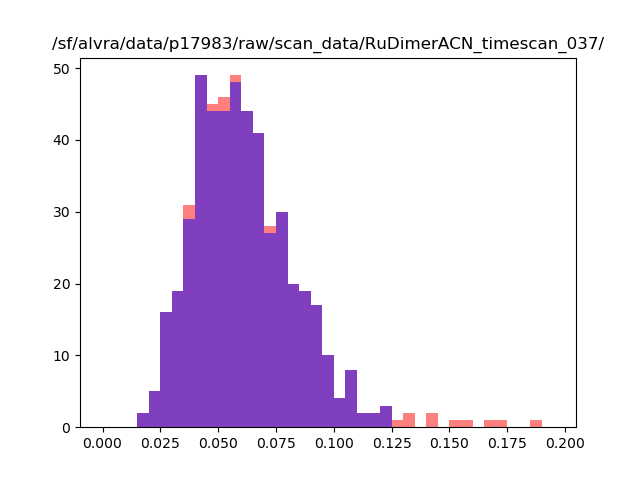

500 483


In [323]:
#num_bins = 100
plt.figure()
plt.hist(IzeroFEL_pump_original, bins =np.arange(0,0.2,0.005), facecolor='red', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.2,0.005), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.title(DIR)
plt.show()
print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

# Load time scan

In [346]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 51

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

DataTrans_pump = []
DataTrans_unpump = []
err_DataTrans_pump = []
err_DataTrans_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []


# from itertools import chain
# concatenated = chain(range(0,37), range(43, 50))
# for i in concatenated:
for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: # and i!=8:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot) = load_PumpProbe_events(filename, channel_delay_SH)
        
        threshold_pump = IzeroFEL_pump_shot > 0.005
        threshold_unpump = IzeroFEL_unpump_shot > 0.005
        condition_pump = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-3*(np.std(IzeroFEL_pump_shot))
        condition_unpump = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-3*(np.std(IzeroFEL_unpump_shot))

        DataFluo_pump_shot = DataFluo_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_pump_shot = DataTrans_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
              
        DataFluo_unpump_shot = DataFluo_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_unpump_shot = DataTrans_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
    
    
              
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        DataTrans_pump_shot_norm = DataTrans_pump_shot / IzeroFEL_pump_shot
        DataTrans_unpump_shot_norm = DataTrans_unpump_shot / IzeroFEL_unpump_shot
              
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        DataFluo_pump.append(DataFluo_pump_shot_norm.mean())
        DataFluo_unpump.append(DataFluo_unpump_shot_norm.mean())
        DataTrans_pump.append(DataTrans_pump_shot_norm.mean())
        DataTrans_unpump.append(DataTrans_unpump_shot_norm.mean())
        
        Pump_probe.append(Pump_probe_shot.mean())
        
        err_DataFluo_pump.append(DataFluo_pump_shot_norm.std()/np.sqrt(DataFluo_pump_shot_norm.size))
        err_DataFluo_unpump.append(DataFluo_unpump_shot_norm.std()/np.sqrt(DataFluo_unpump_shot_norm.size))
        err_DataTrans_pump.append(DataTrans_pump_shot_norm.std()/np.sqrt(DataTrans_pump_shot_norm.size))
        err_DataTrans_unpump.append(DataTrans_unpump_shot_norm.std()/np.sqrt(DataTrans_unpump_shot_norm.size))
              
        err_Pump_probe.append(Pump_probe_shot.std()/np.sqrt(Pump_probe_shot.size))
               
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
DataTrans_pump = np.asarray(DataTrans_pump)
DataTrans_unpump = np.asarray(DataTrans_unpump)
              
Pump_probe = np.asarray(Pump_probe)
err_Pump_probe = np.asarray(err_Pump_probe)
              
err_DataFluo_pump = np.asarray(err_DataFluo_pump)
err_DataFluo_unpump = np.asarray(err_DataFluo_unpump)
err_DataTrans_pump = np.asarray(err_DataTrans_pump)
err_DataTrans_unpump = np.asarray(err_DataTrans_unpump)
            
Delay_mm = np.asarray(Delay_mm)

print ("Job done!")


/sf/alvra/data/p17983/res/scan_info/RuDimerACN_timescan_037_scan_info.json
Processing 11 files
step 1 of 11 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_037/RuDimerACN_timescan_037_step0000.BSREAD.h5
step 2 of 11 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_037/RuDimerACN_timescan_037_step0001.BSREAD.h5
step 3 of 11 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_037/RuDimerACN_timescan_037_step0002.BSREAD.h5
step 4 of 11 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_037/RuDimerACN_timescan_037_step0003.BSREAD.h5
step 5 of 11 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_037/RuDimerACN_timescan_037_step0004.BSREAD.h5
step 6 of 11 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_037/RuDimerACN_timescan_037_step0005.BSREAD.h5
step 7 of 11 : Processing /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_037/RuDimerACN_timescan_037_step0006.BSREAD.h5
st

# Plot time scans

<IPython.core.display.Javascript object>


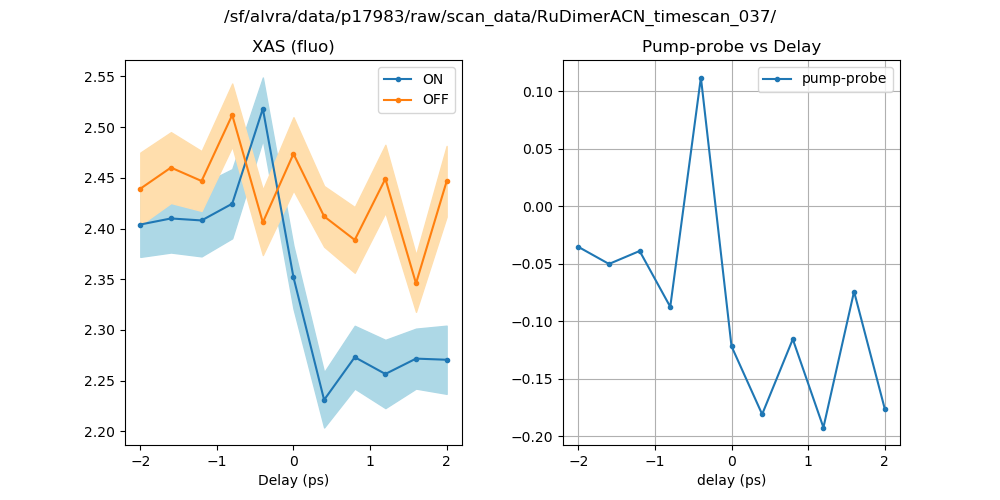

In [347]:
#Timezero = 141.36   # position of Timezero on PP delay (in mm!)
#Timezero = 160.0317   # position of Timezero on PP delay (in mm!)
Timezero = 156.3276   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !
#Delay_ps = Delay_mm
scale=1

offset_corr_DataFluo_pump = scale*DataFluo_pump - np.mean(scale*DataFluo_pump[:3])
offset_corr_DataFluo_unpump = scale*DataFluo_unpump - np.mean(scale*DataFluo_unpump[:3])
offset_corr_pump_probe = offset_corr_DataFluo_pump - offset_corr_DataFluo_unpump


plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)

#plt.title(DIR,horizontalalignment='right')
low_err_pump = DataFluo_pump - err_DataFluo_pump
high_err_pump = DataFluo_pump + err_DataFluo_pump
low_err_unpump = DataFluo_unpump - err_DataFluo_unpump
high_err_unpump = DataFluo_unpump + err_DataFluo_unpump
low_err_pumpprobe = (Pump_probe) - np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)
high_err_pumpprobe = (Pump_probe) + np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)

plt.subplot(1,2,1)
plt.plot(Delay_ps, scale*DataFluo_pump, label="ON",marker='.')
plt.plot(Delay_ps, scale*DataFluo_unpump, label="OFF",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Delay_ps, scale*(Pump_probe), label="pump-probe",marker='.')
#plt.fill_between(Delay_ps, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.grid()
plt.xlabel("delay (ps)")
plt.gca().set_title('Pump-probe vs Delay')
plt.legend(loc="best")

plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

In [316]:
np.save('Ktrace_Bpeak2840.npy', Delay_ps, Pump_probe)

In [317]:
Pump_probe_tofit = (Pump_probe/DataFluo_unpump).copy()
Delay_ps_tofit = Delay_ps.copy()

In [318]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_ps_tofit) | np.isnan(Pump_probe_tofit))

parameters,extras = curve_fit(errfunc_fwhm, Delay_ps_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, 0, 0.5])

print("Position t0 =",np.round(parameters[2],5),"ps")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

Position t0 = 0.19984 ps
Width = 2492.0 fs


<IPython.core.display.Javascript object>


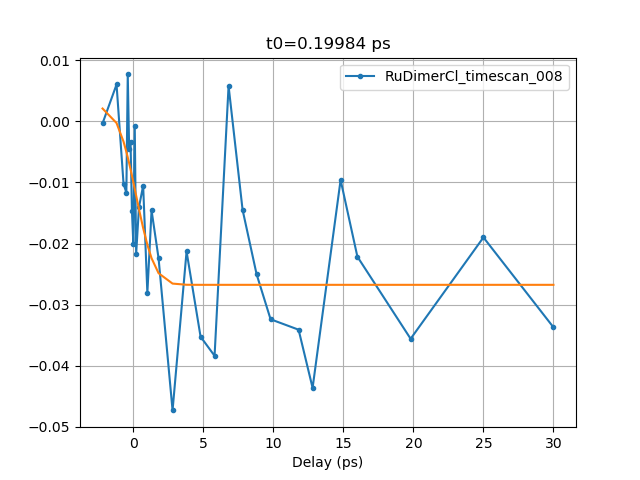

In [319]:
#... and the plot with the fit curve

plt.figure()

plt.plot(Delay_ps_tofit, Pump_probe_tofit, label=f"{scan_name}",marker='.')
plt.plot(Delay_ps_tofit, errfunc_fwhm(Delay_ps_tofit,*parameters))

#low_err = Pump_probe_tofit - err_pump_probe
#high_err = Pump_probe_tofit + err_pump_probe
#plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

#plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
plt.title('t0=' + str(np.round(parameters[2], 5)) + ' ps' )
plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

In [12]:
timelist=np.concatenate((np.arange(-1.5,-0.5-1,-1))-, np.arange(2847,2845.5-.5,-0.5),np.arange(2845,2835.25-.25,-0.25),np.arange(2835,2834.5-.5,-0.5),np.arange(2834,2831-1,-1)))

SyntaxError: invalid syntax (<ipython-input-12-81b80a1fadf0>, line 1)

In [ ]:
def exponential_func(x,a,b,c):
    return a*np.exp(-b*x)+c

def bi_exponential_func(x,a,b,c, d, e):
    return a*np.exp(-b*x)+c+d*np.exp(-e*x)

Delay_ps = np.array(Delay_ps)
t_range = Delay_ps > 0.02 

popt,pcov = curve_fit(exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 10, 0.2))
popt2,pcov2 = curve_fit(bi_exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 0.6, 0.2, 0.4, 6))

xx= np.linspace(0, 20, 100)
yy = exponential_func(xx, *popt)
yyy= bi_exponential_func(xx, *popt2)

plt.figure()
plt.plot(Delay_ps, -Pump_probe)
plt.plot(xx, yy)
plt.plot(xx, yyy)


print(popt)
print(popt2)
